This model applies a 1D CNN to the EEG data.

Load libraries.

In [0]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from google.colab import drive
import matplotlib.pyplot as plt

Mount drive where data is stored.

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pull dataset.

In [0]:
path_prefix = '/content/drive/Shared drives/CS 230 Project (EEG)/'
data = np.load(path_prefix + 's44_data.npy')
labels = np.load(path_prefix + 's44_labels.npy')

Normalize all data across the channels.

In [0]:
means = np.sum(data, axis = (0,2), keepdims = True)/ (data.shape[0] * data.shape[2])
stds = np.sum(np.square(data - means), axis = (0,2), keepdims = True) / (data.shape[0] * data.shape[2])
stds = np.sqrt(stds)
data = (data - means)/stds

Start running code on GPU. Should output true if GPU is being used.

In [5]:
# Start Device
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

print(torch.cuda.is_available())

True


Plot one data sequence (500 points, 30 EEG channels from one session).

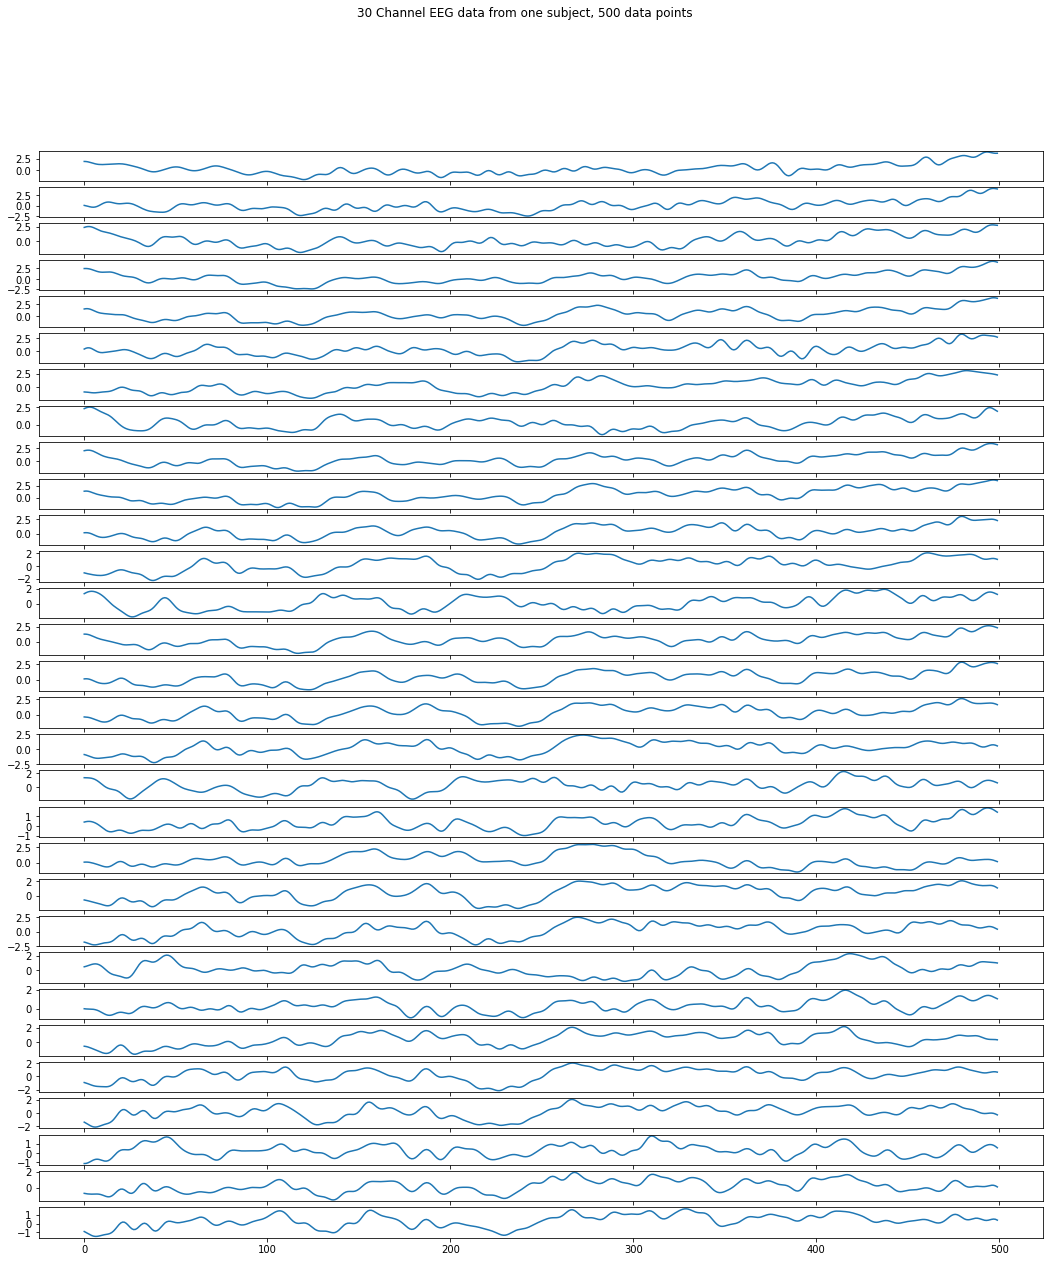

In [6]:
# define constants
N_EVENTS = data.shape[0]
N_CHAN = data.shape[1]
N_DATA_PTS = data.shape[2]

fig, axs = plt.subplots(N_CHAN)
fig.set_size_inches(18, 20)
fig.suptitle('30 Channel EEG data from one subject, 500 data points')
for i in range(data.shape[1]):
    axs[i].plot(data[0, i, :])

Define functions.

In [0]:
def preprocess(x, y):
    """
        Reshapes the data to size [N_EVENTS, N_CHAN, N_DATA_PTS].
        Args:
        x: torch.Tensor[N_EVENTS, N_CHAN*N_DATA_PTS]
        y: torch.Tensor[N_EVENTS]
    """
    return x.view(-1, N_CHAN, N_DATA_PTS).to(dev), y.to(dev)

class Flattener(nn.Module):
    """ 
        Flattens (reshapes) input of size [n_1, n_2, ...] to [n_1*n_2*..., 1].
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)  
        
def get_data(dataset, bs, shuffle):
    """
        Returns an iterable torch.utils.data.DataLoader object that yields 
        batches from the dataset.
        Args: 
        dataset: torch.utils.data.TensorDataset
        bs: Batch Size (int)
        shuffle: Shuffles the dataset content (Bool)
    """
    return DataLoader(dataset, batch_size = bs, shuffle = shuffle)

class WrappedDataLoader:
    """
        Loads data in batches and applies preprocessing function.
        Args:
        func: function handle.
    """
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

def convert_to_dataset(data, labels, indices, bs, shuffle):
    """
    Converts Python data to torch.utils.data.DataLoader object.
    Args:
    data: EEG signal [N_EVENTS, N_CHAN, N_DATA_PTS]
    labels: Reaction Time Label (0, 1), [N_EVENTS,]
    indices: indices corresponding to either train, validation or test sets (int)
    bs: Batch Size (int)
    shuffle: (Bool)
    """
    x, y = data[indices], labels[indices]

    # Reshape dataset to (N_samples, W*H).
    x.reshape([x.shape[0], -1])
    y.squeeze()
    x = torch.tensor(x, dtype = torch.float)
    y = torch.tensor(y, dtype = torch.float)
    dataset = get_data(TensorDataset(x, y), bs, shuffle)
    return WrappedDataLoader(dataset, preprocess) 

def loss_batch(model, loss_func, xb, yb, opt=None):
    """
    Computes loss across a batch.
    Args:
    model: the network object (torch.nn.Sequential)
    loss_func: loss function of the network (torch.nn.Functional)
    xb: batch data from torch.utils.data.DataLoader
    yb: batch label from torch.utils.data.DataLoader
    opt: optimizer (torch.optim)
    """
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def split_dataset(data, labels, split_ratios):
    """
        Splits the dataset to train, validation and test sets.
        Args: 
        data: dataset [N_EVENTS, N_CHAN, N_DATA_PTS]
        labels: reaction time labels [N_EVENTS,]
        split_ratios: (out of 100) splitting ratios for train, validation and test sets (int) [3,]
    """
    dataset_indices = np.arange(data.shape[0])
    
    # set seed to obtain same results across trials
    np.random.seed(0)
    
    # shuffle data indices 
    np.random.shuffle(dataset_indices)
    
    # split to train, validation and test sets
    train_indices =   dataset_indices[ : data.shape[0] * split_ratios[0] // 100]
    valid_indices =   dataset_indices[ data.shape[0] * split_ratios[0] // 100 : data.shape[0] * (split_ratios[0] + split_ratios[1]) // 100]
    test_indices  =   dataset_indices[ data.shape[0] * (split_ratios[0] + split_ratios[1]) // 100 : ]

    # convert to tensorflow dataloaders
    train_dl = convert_to_dataset(data, labels, train_indices, bs, True)
    valid_dl = convert_to_dataset(data, labels, valid_indices, 2 * bs, False)
    test_dl  = convert_to_dataset(data, labels, test_indices, 2 * bs, False )

    return train_dl, valid_dl, test_dl

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    """
    Trains the network.
    Args:
    epochs: number of epochs to train the network - hyperparameter (int)
    model: the network object (torch.nn.Sequential)
    loss_func: loss function of the network (torch.nn.Functional)
    opt: optimizer (torch.optim)
    train_dl: training data loader iterable (torch.utils.data.DataLoader)
    valid_dl: validation data loader iterable (torch.utils.data.DataLoader)
    """
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [0]:
def test(model, test_dl):
    nums = 0
    correct_predictions = 0

    #Precision - how many positive predictions were correct 
    pos_pred = 0
    pos_true = 0

    #Recall - how many real positive values were detected
    pos_all = 0
    
    model.eval()
    for xb, yb in test_dl:
        raw_predict = model.forward(xb)
        predictions = torch.round(raw_predict)

        #Calculate precision
        pred_pos = torch.sum(predictions == 1)
        true_pos = (predictions == 1) * (yb == 1)
        true_pos = torch.sum(true_pos)
        pos_pred += pred_pos.cpu().numpy()
        pos_true += true_pos.cpu().numpy()

        print("True Positives: " + str(true_pos.cpu().numpy()))
        print("Positive Predictions: " + str(pred_pos.cpu().numpy()))

        #Calculate recall
        all_pos = torch.sum(yb)
        pos_all += all_pos.cpu().numpy()

        print("Actual Positives: " + str(all_pos.cpu().numpy()))

        compare = (predictions == yb)
        correct = torch.sum(compare)
        correct_predictions = correct_predictions + correct
        nums = nums + yb.shape[0]
        print("/////////////////////////")
        
    test_accuracy = correct_predictions.cpu().numpy() / nums
    precision = pos_true/pos_pred
    recall = pos_true/pos_all
    f1 = 2*precision*recall/(precision + recall)

    print("Accuracy: " + str(test_accuracy))
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F1: " + str(f1))

**Initialize Dataloaders**

In [0]:
bs = 64         # batch size
# Split the dataset into train (60%), validation (20%) and test (20%).
train_dl, test_dl, valid_dl = split_dataset(data, labels, split_ratios = [60, 20, 20])

# Clear dataset variables once read.
data = None
label = None

**Set hyperparameters**

In [0]:
lr = 1.8e-3         # learning rate
epochs = 100        # how many epochs to train for
momentum = 0.9        # SGD momentum parameter
# Set the loss function
loss_func = F.binary_cross_entropy

# Set seed for reproducibility, comment to make random
#torch.manual_seed(0)

Shuffle dataset and separate to train, validation and test sets. Clear dataset variables once read.

In [0]:
"""
# Initialize Convolutional Neural Network Model
model = nn.Sequential(
    nn.Conv1d(N_CHAN, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv1d(10, 5, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv1d(5, 3, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Flattener(),
    # Fully connected layer
    nn.Linear(in_features = 3 * N_DATA_PTS // 2, out_features = 100),
    nn.ReLU(),
    nn.Linear(in_features = 100, out_features = 60),
    nn.ReLU(),
    nn.Linear(in_features = 60, out_features = 1),
    nn.Sigmoid()
)
"""
total_epochs = 0
# Best Model so far
# Initialize Convolutional Neural Network Model
model = nn.Sequential(
    nn.Conv1d(N_CHAN, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv1d(10, 5, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv1d(5, 3, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    Flattener(),
    # Fully connected layer
    nn.Linear(in_features = 3 * N_DATA_PTS // 2, out_features = 100),
    nn.ReLU(),
    nn.Linear(in_features = 100, out_features = 1),
    nn.Sigmoid()
)

In [180]:
# Run CNN
total_epochs += epochs
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print('Start training.')
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
print('End of training.')

Start training.
0 0.6935276951624717
1 0.6933785295073605
2 0.6932608792276094
3 0.6931796561587941
4 0.6931007158704651
5 0.6930294547762189
6 0.6929326209671054
7 0.6928826250555196
8 0.692841547908205
9 0.6927818800463821
10 0.6927233131933006
11 0.692708478861557
12 0.6926860731917542
13 0.6926398478545152
14 0.6925887708024029
15 0.6925595384655576
16 0.6925333000364757
17 0.692492619995431
18 0.6924626465999719
19 0.6924168663623529
20 0.6923660052803172
21 0.6923327724654953
22 0.692284362140672
23 0.6922433053776299
24 0.692216153526719
25 0.6921671445751603
26 0.6921231790538475
27 0.6920629117912028
28 0.6919906405143408
29 0.6919443256411202
30 0.6918664259828015
31 0.6918194286234967
32 0.6917677462359011
33 0.6917134407278779
34 0.6916141357772794
35 0.6915310469024625
36 0.691449946139282
37 0.6913828067965322
38 0.6913218534354008
39 0.6912268947213243
40 0.6911490133830479
41 0.6910442885382351
42 0.6909554113041271
43 0.6908410067682142
44 0.6907038564805861
45 0.69058

In [0]:
#model = model.load_state_dict(torch.load('/content/drive/Shared drives/CS 230 Project (EEG)/cnn1d_eeg_ziad5.pth'))


Test the model. Print the percentage of correctly classified labels.

In [181]:
test(model, test_dl)

True Positives: 49
Positive Predictions: 71
Actual Positives: 65.0
/////////////////////////
True Positives: 50
Positive Predictions: 76
Actual Positives: 64.0
/////////////////////////
True Positives: 64
Positive Predictions: 79
Actual Positives: 77.0
/////////////////////////
True Positives: 28
Positive Predictions: 42
Actual Positives: 41.0
/////////////////////////
Accuracy: 0.7121212121212122
Precision: 0.7126865671641791
Recall: 0.7732793522267206
F1: 0.741747572815534


In [182]:
PATH = './cnn1d_eeg_tolga3.pth'
print('Save state of network...')
answer = None
while answer not in ("Y", "N"):
    answer = input("Enter Y or N: ")
    if answer == "Y": # Save the current state of the network.
        torch.save(model.state_dict(), PATH)
        np.save('hyperparameters', [bs, lr, total_epochs, momentum] )
        print('State of the network was saved.')
    elif answer == "N": # Move on without saving.
        print('State of the network was NOT saved.')
        continue
    else:
        print("Please enter yes or no.")

Save state of network...
Enter Y or N: Y
State of the network was saved.


In [0]:
[bs1, lr1, total_epochs1, momentum1] = np.load('hyperparameters.npy')

In [185]:
bs1

64.0

In [186]:
lr1

0.0018

In [187]:
total_epochs

100